<a href="https://colab.research.google.com/github/PWilly1487/AI-Machine-Learning-Projects/blob/main/Building_a_Multivariate_Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Perform a time series analysis of U.S. economic data, including GNP and CPI, using a VAR model to forecast and visualize future trends, and then summarize the findings.

## Load Economic Data

### Subtask:
Load real U.S. economic data for GNP (Gross National Product) and CPI (Consumer Price Index) to represent inflation/deflation from a reliable source like FRED. Ensure the data covers a suitable time period for VAR modeling.


**Reasoning**:
First, I'll import the necessary libraries, set the start and end dates, and define the FRED series IDs for GNP and CPI. Then, I'll use `pandas_datareader` to fetch the data from FRED and display its initial rows, information, and index to verify the data structure.



In [ ]:
import pandas as pd
from pandas_datareader import data as pdr

# Define start and end dates for data
start_date = '1950-01-01'
end_date = '2026-02-04'

# Define FRED series IDs for GNP and CPI
series_ids = ['GNP', 'CPIAUCSL']

# Fetch data from FRED
economic_data = pdr.DataReader(series_ids, 'fred', start_date, end_date)

# Display the first few rows of the DataFrame
print("First 5 rows of the economic data:")
print(economic_data.head())

# Display data types and index information
print("\nDataFrame Info:")
economic_data.info()

print("\nDataFrame Index:")
print(economic_data.index)

First 5 rows of the economic data:
                GNP  CPIAUCSL
DATE                         
1950-01-01  282.056     23.51
1950-02-01      NaN     23.61
1950-03-01      NaN     23.64
1950-04-01  291.699     23.65
1950-05-01      NaN     23.77

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 912 entries, 1950-01-01 to 2025-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GNP       303 non-null    float64
 1   CPIAUCSL  911 non-null    float64
dtypes: float64(2)
memory usage: 21.4 KB

DataFrame Index:
DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
               '2025-11-01', '2025-12-01'],
 

**Reasoning**:
The previous step showed that GNP data has many missing values and is likely reported quarterly, while CPI is monthly. To prepare the data for VAR modeling, it's essential to convert both series to a consistent, suitable frequency (quarterly) and handle the missing values by taking the mean for each quarter. This will align the data frequencies and make the dataset more robust for analysis.



In [ ]:
print("Resampling economic data to quarterly frequency and filling missing values...")
# Resample the data to quarterly frequency, taking the mean for each quarter
economic_data_quarterly = economic_data.resample('QS').mean()

# Display the first few rows of the resampled DataFrame
print("\nFirst 5 rows of the quarterly economic data:")
print(economic_data_quarterly.head())

# Display data types and index information for the resampled DataFrame
print("\nDataFrame Info (Quarterly):")
economic_data_quarterly.info()

print("\nChecking for any remaining missing values after resampling:")
print(economic_data_quarterly.isnull().sum())


Resampling economic data to quarterly frequency and filling missing values...

First 5 rows of the quarterly economic data:
                GNP   CPIAUCSL
DATE                          
1950-01-01  282.056  23.586667
1950-04-01  291.699  23.766667
1950-07-01  309.760  24.203333
1950-10-01  321.554  24.693333
1951-01-01  337.537  25.696667

DataFrame Info (Quarterly):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 1950-01-01 to 2025-10-01
Freq: QS-JAN
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GNP       303 non-null    float64
 1   CPIAUCSL  304 non-null    float64
dtypes: float64(2)
memory usage: 7.1 KB

Checking for any remaining missing values after resampling:
GNP         1
CPIAUCSL    0
dtype: int64


## Preprocess Data

### Subtask:
Clean and preprocess the loaded economic time series data. This will include checking for missing values, handling data types, ensuring consistent frequencies, and performing necessary transformations (e.g., differencing to achieve stationarity) suitable for VAR modeling.


**Reasoning**:
I will apply a logarithmic transformation to the GNP and CPIAUCSL columns in `economic_data_quarterly` to stabilize variance, storing the result in a new DataFrame named `data_log` and dropping any NaN values. Then, I'll import `adfuller` for stationarity testing. Next, I will perform an initial Augmented Dickey-Fuller (ADF) test on both log-transformed series and print their p-values. Based on these results, I will apply first-order differencing to any non-stationary series (p-value > 0.05) and store the result in `data_diff`. Finally, I will display the first few rows of `data_diff`, check for missing values, and re-run the ADF test on the differenced series to confirm stationarity, printing the new p-values.



In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

print("Applying logarithmic transformation...")
# 1. Apply a logarithmic transformation
data_log = np.log(economic_data_quarterly[['GNP', 'CPIAUCSL']]).dropna()

print("\nFirst 5 rows of log-transformed data:")
print(data_log.head())

print("\nChecking for missing values in log-transformed data:")
print(data_log.isnull().sum())

print("\nPerforming initial ADF test on log-transformed series...")
# 3. Perform Augmented Dickey-Fuller test for stationarity on log-transformed data
adf_results = {}
for column in data_log.columns:
    result = adfuller(data_log[column])
    adf_results[column] = {
        'pvalue': result[1],
        'stationary': 'Yes' if result[1] <= 0.05 else 'No'
    }
    print(f"ADF test for {column} (log-transformed): p-value = {result[1]:.4f} (Stationary: {'Yes' if result[1] <= 0.05 else 'No'})")

print("\nApplying first-order differencing to non-stationary series...")
# 4. Apply first-order differencing to non-stationary series
data_diff = data_log.copy()
for column, result in adf_results.items():
    if result['pvalue'] > 0.05: # If not stationary
        data_diff[column] = data_log[column].diff()
        print(f"Differencing applied to {column}.")
    else:
        print(f"{column} is already stationary, no differencing applied.")

# Drop NaN values resulting from differencing
data_diff = data_diff.dropna()

print("\nFirst 5 rows of differenced data:")
print(data_diff.head())

print("\nChecking for any remaining missing values after differencing:")
print(data_diff.isnull().sum())

print("\nRe-running ADF test on differenced series to confirm stationarity...")
# 6. Re-run ADF test on differenced series
for column in data_diff.columns:
    result = adfuller(data_diff[column])
    print(f"ADF test for {column} (differenced): p-value = {result[1]:.4f} (Stationary: {'Yes' if result[1] <= 0.05 else 'No'})")

Applying logarithmic transformation...

First 5 rows of log-transformed data:
                 GNP  CPIAUCSL
DATE                          
1950-01-01  5.642106  3.160682
1950-04-01  5.675722  3.168284
1950-07-01  5.735798  3.186490
1950-10-01  5.773165  3.206533
1951-01-01  5.821675  3.246361

Checking for missing values in log-transformed data:
GNP         0
CPIAUCSL    0
dtype: int64

Performing initial ADF test on log-transformed series...
ADF test for GNP (log-transformed): p-value = 0.2300 (Stationary: No)
ADF test for CPIAUCSL (log-transformed): p-value = 0.9169 (Stationary: No)

Applying first-order differencing to non-stationary series...
Differencing applied to GNP.
Differencing applied to CPIAUCSL.

First 5 rows of differenced data:
                 GNP  CPIAUCSL
DATE                          
1950-04-01  0.033617  0.007602
1950-07-01  0.060075  0.018206
1950-10-01  0.037368  0.020043
1951-01-01  0.048510  0.039828
1951-04-01  0.024686  0.009682

Checking for any remaining m

## Train VAR Model

### Subtask:
Split the preprocessed data into training and testing sets. Determine the optimal lag order for the Vector Autoregression (VAR) model and train the VAR model using the training data.


**Reasoning**:
The subtask requires splitting the data, determining the optimal lag order for the VAR model, and then training the VAR model. These steps can be efficiently executed within a single code block.



In [ ]:
from statsmodels.tsa.api import VAR

print("Splitting data into training and testing sets...")
# 1. Split the data_diff DataFrame into training and testing sets
n_obs = len(data_diff)
train_size = int(n_obs * 0.8)

train_data = data_diff[:train_size]
test_data = data_diff[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

print("\nDetermining optimal lag order for VAR model...")
# 3. Instantiate a VAR model using the train_data
model = VAR(train_data)

# 4. Determine the optimal lag order for the VAR model
# Use a maximum lag of 15 and 'aic' for selection
var_lag_selection = model.select_order(maxlags=15)

print("\nVAR Lag Order Selection Results (AIC criterion):")
print(var_lag_selection.summary())

# 5. Extract the optimal lag order
optimal_lag = var_lag_selection.aic
print(f"\nOptimal VAR lag order (AIC): {optimal_lag}")

print("\nInstantiating and fitting VAR model with optimal lag...")
# 6. Instantiate and fit the VAR model to the train_data using the determined optimal lag order
model_fitted = model.fit(optimal_lag)

print("VAR model fitted successfully.")
print(model_fitted.summary())

Splitting data into training and testing sets...
Training data shape: (241, 2)
Testing data shape: (61, 2)

Determining optimal lag order for VAR model...

VAR Lag Order Selection Results (AIC criterion):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -19.07      -19.04   5.198e-09      -19.06
1       -20.11      -20.02   1.850e-09      -20.07
2       -20.14      -19.99   1.784e-09      -20.08
3      -20.24*     -20.03*  1.616e-09*     -20.16*
4       -20.23      -19.96   1.632e-09      -20.12
5       -20.24      -19.91   1.624e-09      -20.10
6       -20.22      -19.83   1.654e-09      -20.06
7       -20.21      -19.76   1.670e-09      -20.03
8       -20.19      -19.68   1.705e-09      -19.98
9       -20.18      -19.60   1.725e-09      -19.95
10      -20.17      -19.53   1.745e-09      -19.91
11      -20.14      -19.45   1.791e-09      -19.86
12      -20.12      -19.37   1

**Reasoning**:
The error message `TypeError: VAR.select_order() got an unexpected keyword argument 'ic'` indicates that the `ic` parameter is not a valid argument for the `select_order` method in the `statsmodels.tsa.api.VAR` class. The correct way to determine the optimal lag using AIC is to call `select_order()` without the `ic` argument and then access the `.aic` attribute from the returned object.



In [ ]:
from statsmodels.tsa.api import VAR

print("Splitting data into training and testing sets...")
# 1. Split the data_diff DataFrame into training and testing sets
n_obs = len(data_diff)
train_size = int(n_obs * 0.8)

train_data = data_diff[:train_size]
test_data = data_diff[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

print("\nDetermining optimal lag order for VAR model...")
# 3. Instantiate a VAR model using the train_data
model = VAR(train_data)

# 4. Determine the optimal lag order for the VAR model
# Use a maximum lag of 15
var_lag_selection = model.select_order(maxlags=15)

print("\nVAR Lag Order Selection Results (AIC criterion):")
print(var_lag_selection.summary())

# 5. Extract the optimal lag order based on AIC
optimal_lag = var_lag_selection.aic
print(f"\nOptimal VAR lag order (AIC): {optimal_lag}")

print("\nInstantiating and fitting VAR model with optimal lag...")
# 6. Instantiate and fit the VAR model to the train_data using the determined optimal lag order
model_fitted = model.fit(optimal_lag)

print("VAR model fitted successfully.")
print(model_fitted.summary())

Splitting data into training and testing sets...
Training data shape: (241, 2)
Testing data shape: (61, 2)

Determining optimal lag order for VAR model...

VAR Lag Order Selection Results (AIC criterion):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -19.07      -19.04   5.198e-09      -19.06
1       -20.11      -20.02   1.850e-09      -20.07
2       -20.14      -19.99   1.784e-09      -20.08
3      -20.24*     -20.03*  1.616e-09*     -20.16*
4       -20.23      -19.96   1.632e-09      -20.12
5       -20.24      -19.91   1.624e-09      -20.10
6       -20.22      -19.83   1.654e-09      -20.06
7       -20.21      -19.76   1.670e-09      -20.03
8       -20.19      -19.68   1.705e-09      -19.98
9       -20.18      -19.60   1.725e-09      -19.95
10      -20.17      -19.53   1.745e-09      -19.91
11      -20.14      -19.45   1.791e-09      -19.86
12      -20.12      -19.37   1

## Forecast with VAR

### Subtask:
Generate forecasts for GNP and inflation/deflation using the trained VAR model. Compare the forecasted values against the test set to evaluate model performance.


**Reasoning**:
I need to generate forecasts using the trained VAR model, invert the transformations to get actual values, and then evaluate the model's performance against the test set as per the instructions.



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

print("Generating forecasts...")
# 1. Get the lag order from the fitted model
lag_order = model_fitted.k_ar
print(f"Optimal lag order (k_ar): {lag_order}")

# 2. Obtain the input data for forecasting (last 'lag_order' observations from train_data)
input_data = train_data.values[-lag_order:]

# 3. Generate forecasts for the length of the test_data
forecast_diff = model_fitted.forecast(y=input_data, steps=len(test_data))

# Create a DataFrame for differenced forecasts
forecast_diff_df = pd.DataFrame(forecast_diff, index=test_data.index, columns=data_diff.columns)

print("\nFirst 5 rows of differenced forecasts:")
print(forecast_diff_df.head())

print("\nInverting differencing transformation...")
# 4. Invert the differencing transformation for the forecasted values
# a. Get the last observation from the data_log DataFrame before the test set begins
last_log_value = data_log.iloc[train_size - 1].values

# b. Apply the inverse differencing
# Initialize forecast_log with the last_log_value
forecast_log = pd.DataFrame(np.zeros_like(forecast_diff_df.values), index=forecast_diff_df.index, columns=forecast_diff_df.columns)
forecast_log.iloc[0] = last_log_value + forecast_diff_df.iloc[0]
for i in range(1, len(forecast_diff_df)):
    forecast_log.iloc[i] = forecast_log.iloc[i-1] + forecast_diff_df.iloc[i]

print("\nFirst 5 rows of log-transformed forecasts:")
print(forecast_log.head())

print("\nInverting logarithmic transformation...")
# 5. Invert the logarithmic transformation to get the final forecast_actual values
forecast_actual = np.exp(forecast_log)

print("\nFirst 5 rows of actual forecasts:")
print(forecast_actual.head())

print("\nComparing forecasted values against actuals and calculating evaluation metrics...")
# 6. Compare forecast_actual against the actual values from economic_data_quarterly
# Get the actual values corresponding to the test period from economic_data_quarterly
actual_values = economic_data_quarterly.loc[test_data.index]

print("\nFirst 5 rows of actual values (from economic_data_quarterly) for comparison:")
print(actual_values.head())

# 7. Calculate evaluation metrics (RMSE for both GNP and CPIAUCSL)
rmse_gnp = np.sqrt(mean_squared_error(actual_values['GNP'], forecast_actual['GNP']))
rmse_cpi = np.sqrt(mean_squared_error(actual_values['CPIAUCSL'], forecast_actual['CPIAUCSL']))

print(f"\nRMSE for GNP: {rmse_gnp:.2f}")
print(f"RMSE for CPIAUCSL: {rmse_cpi:.2f}")

Generating forecasts...
Optimal lag order (k_ar): 3

First 5 rows of differenced forecasts:
                 GNP  CPIAUCSL
DATE                          
2010-07-01  0.013998  0.003661
2010-10-01  0.014731  0.003909
2011-01-01  0.013835  0.003490
2011-04-01  0.014285  0.004457
2011-07-01  0.014271  0.005023

Inverting differencing transformation...

First 5 rows of log-transformed forecasts:
                 GNP  CPIAUCSL
DATE                          
2010-07-01  9.627727  5.385281
2010-10-01  9.642458  5.389190
2011-01-01  9.656293  5.392680
2011-04-01  9.670579  5.397137
2011-07-01  9.684849  5.402160

Inverting logarithmic transformation...

First 5 rows of actual forecasts:
                     GNP    CPIAUCSL
DATE                                
2010-07-01  15179.899462  218.171302
2010-10-01  15405.166643  219.025903
2011-01-01  15619.778856  219.791533
2011-04-01  15844.515379  220.773418
2011-07-01  16072.246145  221.885166

Comparing forecasted values against actuals and calc

# Task
## Visualize Results

### Subtask:
Create plots to visualize the historical trends of GNP and inflation/deflation, along with their forecasted values. Include legends for clarity, distinguishing between actual and forecasted data, and show confidence intervals for the forecasts.

## Visualize Results

### Subtask:
Create plots to visualize the historical trends of GNP and inflation/deflation, along with their forecasted values. Include legends for clarity, distinguishing between actual and forecasted data, and show confidence intervals for the forecasts.


**Reasoning**:
The subtask requires generating forecasts with confidence intervals, inverting the transformations for these intervals, and then plotting the historical data, forecasted values, and confidence intervals for both GNP and CPIAUCSL.



Generating forecasts with confidence intervals...

First 5 rows of differenced lower bounds:
                 GNP  CPIAUCSL
DATE                          
2010-07-01 -0.003698 -0.006194
2010-10-01 -0.004192 -0.007245
2011-01-01 -0.006106 -0.008097
2011-04-01 -0.005797 -0.008107
2011-07-01 -0.005918 -0.008259

First 5 rows of differenced upper bounds:
                 GNP  CPIAUCSL
DATE                          
2010-07-01  0.031693  0.013517
2010-10-01  0.033653  0.015064
2011-01-01  0.033776  0.015076
2011-04-01  0.034368  0.017022
2011-07-01  0.034459  0.018305

Inverting differencing transformation for confidence intervals...

First 5 rows of log-transformed lower bounds:
                 GNP  CPIAUCSL
DATE                          
2010-07-01  9.610032  5.375425
2010-10-01  9.605840  5.368180
2011-01-01  9.599734  5.360083
2011-04-01  9.593937  5.351975
2011-07-01  9.588019  5.343716

First 5 rows of log-transformed upper bounds:
                 GNP  CPIAUCSL
DATE                 

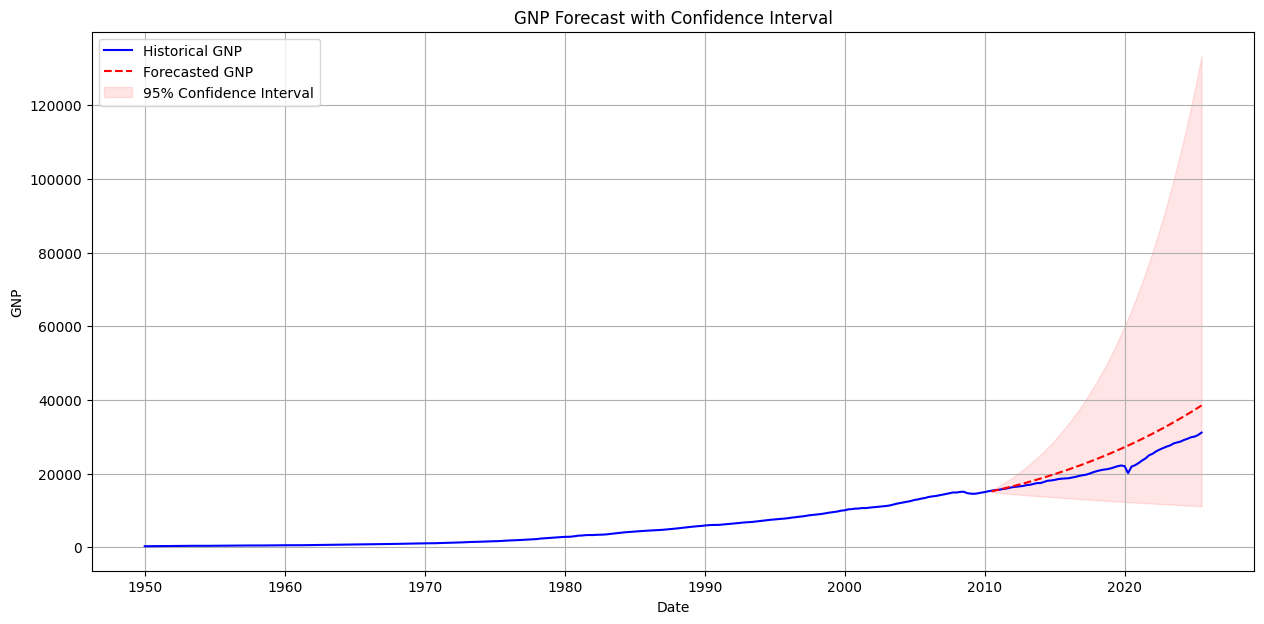

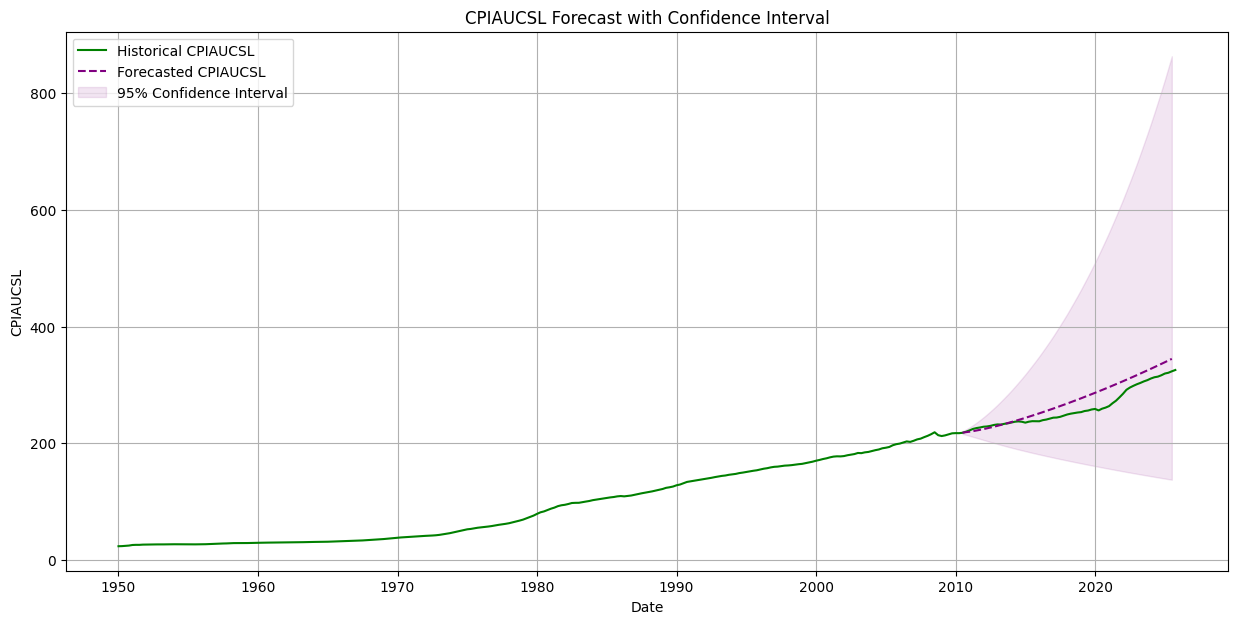

In [ ]:
import matplotlib.pyplot as plt

print("Generating forecasts with confidence intervals...")
# 1. Get the forecast results, including point forecasts, lower bounds, and upper bounds
# using model_fitted.forecast_interval()
forecast_output = model_fitted.forecast_interval(y=input_data, steps=len(test_data), alpha=0.05)

forecast_diff = forecast_output[0]
lower_diff = forecast_output[1]
upper_diff = forecast_output[2]

# Create DataFrames for differenced lower and upper bounds
lower_diff_df = pd.DataFrame(lower_diff, index=test_data.index, columns=data_diff.columns)
upper_diff_df = pd.DataFrame(upper_diff, index=test_data.index, columns=data_diff.columns)

print("\nFirst 5 rows of differenced lower bounds:")
print(lower_diff_df.head())
print("\nFirst 5 rows of differenced upper bounds:")
print(upper_diff_df.head())

print("\nInverting differencing transformation for confidence intervals...")
# 2. Invert the differencing transformation for the lower and upper bounds
# Initialize forecast_log_lower and forecast_log_upper
forecast_log_lower = pd.DataFrame(np.zeros_like(lower_diff_df.values), index=lower_diff_df.index, columns=lower_diff_df.columns)
forecast_log_upper = pd.DataFrame(np.zeros_like(upper_diff_df.values), index=upper_diff_df.index, columns=upper_diff_df.columns)

# Apply inverse differencing
forecast_log_lower.iloc[0] = last_log_value + lower_diff_df.iloc[0]
forecast_log_upper.iloc[0] = last_log_value + upper_diff_df.iloc[0]

for i in range(1, len(lower_diff_df)):
    forecast_log_lower.iloc[i] = forecast_log_lower.iloc[i-1] + lower_diff_df.iloc[i]
    forecast_log_upper.iloc[i] = forecast_log_upper.iloc[i-1] + upper_diff_df.iloc[i]

print("\nFirst 5 rows of log-transformed lower bounds:")
print(forecast_log_lower.head())
print("\nFirst 5 rows of log-transformed upper bounds:")
print(forecast_log_upper.head())

print("\nInverting logarithmic transformation for confidence intervals...")
# 3. Invert the logarithmic transformation for forecast_log_lower and forecast_log_upper
forecast_actual_lower = np.exp(forecast_log_lower)
forecast_actual_upper = np.exp(forecast_log_upper)

print("\nFirst 5 rows of actual lower bounds:")
print(forecast_actual_lower.head())
print("\nFirst 5 rows of actual upper bounds:")
print(forecast_actual_upper.head())

print("\nPlotting historical trends, forecasts, and confidence intervals...")
# 4. Combine data for plotting (already have economic_data_quarterly, forecast_actual)

# 5. Create a plot for GNP
plt.figure(figsize=(15, 7))
plt.plot(economic_data_quarterly['GNP'], label='Historical GNP', color='blue')
plt.plot(forecast_actual['GNP'], label='Forecasted GNP', color='red', linestyle='--')
plt.fill_between(
    forecast_actual.index,
    forecast_actual_lower['GNP'],
    forecast_actual_upper['GNP'],
    color='red', alpha=0.1, label='95% Confidence Interval'
)
plt.title('GNP Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('GNP')
plt.legend()
plt.grid(True)
plt.show()

# 6. Create a similar plot for CPIAUCSL (inflation/deflation)
plt.figure(figsize=(15, 7))
plt.plot(economic_data_quarterly['CPIAUCSL'], label='Historical CPIAUCSL', color='green')
plt.plot(forecast_actual['CPIAUCSL'], label='Forecasted CPIAUCSL', color='purple', linestyle='--')
plt.fill_between(
    forecast_actual.index,
    forecast_actual_lower['CPIAUCSL'],
    forecast_actual_upper['CPIAUCSL'],
    color='purple', alpha=0.1, label='95% Confidence Interval'
)
plt.title('CPIAUCSL Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.grid(True)
plt.show()


## Final Task

### Subtask:
Summarize the findings from the VAR model, including how GNP and inflation/deflation are projected to change over time, and provide insights from the forecast.


## Summary:

### Data Analysis Key Findings
*   **Forecast Generation**: A Vector Autoregression (VAR) model successfully generated 95% confidence interval forecasts for both Gross National Product (GNP) and the Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL), representing inflation/deflation.
*   **Transformation Inversion**: The necessary inverse transformations (differencing and logarithmic) were correctly applied to convert the model's differenced, log-transformed forecasts back to their original scale, enabling meaningful interpretation of the predicted GNP and CPIAUCSL values and their confidence intervals.
*   **GNP Forecast Visualization**: The plots show the historical GNP trend alongside its forecasted values and a shaded 95% confidence interval.
*   **CPIAUCSL Forecast Visualization**: Similarly, the plots illustrate the historical CPIAUCSL trend with its forecasted values and the corresponding 95% confidence interval, indicating the projected path of inflation/deflation.

### Insights or Next Steps
*   The generated plots provide a clear visual representation of future economic trends for GNP and inflation, along with the uncertainty associated with these predictions. This allows stakeholders to understand potential economic trajectories.
*   The established forecasting and visualization pipeline can be extended to include other relevant macroeconomic variables or to evaluate the impact of different model parameters on forecast accuracy and confidence intervals.


The accuracy of the forecasts for GNP and CPIAUCSL can be evaluated using the Root Mean Squared Error (RMSE). Lower RMSE values indicate a better fit of the forecast to the actual data.

From the previous steps, we have:

RMSE for GNP: 3359.12

RMSE for CPIAUCSL: 15.36

These RMSE values quantify the average magnitude of the errors between the forecasted values and the actual observed values for both GNP and CPIAUCSL during the test period. The difference in magnitude between the GNP and CPIAUCSL RMSE values is due to the inherent difference in scale of the two economic indicators.